# Setup

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession,Window
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("Mateus") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.sql.files.maxPartitionBytes", "128MB") \
    .config("spark.sql.files.openCostInBytes", "4MB")  \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.driver.memory", "16g")  \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "4")  \
    .getOrCreate()

conn = duckdb.connect('r2_prata.duckdb')
conn.execute("ATTACH 'r2_ouro.duckdb' AS r2_ouro")


def sql(query,conn=conn):
    return conn.execute(query).fetch_df()

show_tables_prata_query = """ SELECT DISTINCT table_name FROM information_schema.tables WHERE table_catalog = 'r2_prata' """


show_tables_ouro_query = """ SELECT DISTINCT table_name FROM information_schema.tables WHERE table_catalog = 'r2_ouro' """

In [2]:
def raio_medio(estacoes,lista_estacoes):
    """ Essa função calcula o raio médio da distância entre a estação base e as estações vizinhas selecionadas.
    ~ estacoes: dataframe pandas com a relação de distancias entre a estação base e todas as estações vizinhas
    ~ lista_estacoes: lista de estações vizinhas a serem consideradas    
    """
    return estacoes.loc[estacoes['id_estacao_vizinha'].isin(lista_estacoes)]['distancia_km'].mean()

def selecionar_estacoes_vizinhas(estacoes,id_estacao_base,n_min,n_max,p,threshold,incr):
    """
    Essa função fornece, dada uma estação base, entre n_min a n_max estações que mais contribuem para a previsão da estação base.
    Para isso, a estação vizinha deve preencher no mínimo 85% dos dados da estação base, e o raio médio das estações 
    vizinhas escolhidas não deve ultrapassar o threshold. Caso não seja possível atingir n_min com essas regras,
    o threshold é relaxado, aumentando no valor de incr por tentativa, até que se tenha n_min estações vizinhas.
    """
    
    estacoes_escolhidas = []
    minimo_atingido = False
    filtered_estacoes = estacoes.loc[estacoes['id_estacao_base']==id_estacao_base]
    for id_estacao in filtered_estacoes['id_estacao_vizinha']:
        # Checa se já foi atingido o limite máximo de estacoes
        if len(estacoes_escolhidas) >= n_max:
            break

        # Checa se já foi atingido o limite mínimo de estacoes 
        if len(estacoes_escolhidas) >= n_min:
            minimo_atingido = True

        # Checa se a porcentagem de dados faltantes na interseção está aceitável
        if filtered_estacoes.loc[filtered_estacoes['id_estacao_vizinha']==id_estacao]['pct_dados_faltantes_intersecao'].iloc[0]<=p:
            r_avg = raio_medio(filtered_estacoes,estacoes_escolhidas+[id_estacao])
            if r_avg <= threshold:
                estacoes_escolhidas.append(id_estacao)
            elif not minimo_atingido:
                threshold += (r_avg-threshold)/incr
                estacoes_escolhidas.append(id_estacao)
            else:
                break
        else:
            pass
    return estacoes_escolhidas

def obter_estacoes_vizinhas_all(estacoes,n_min,n_max,p,threshold,incr):
    """
    Essa função aplica a função selecionar_estacoes_vizinhas a todas as estações do dataframe estacoes, e retorna
    um dicionário com o resultado.
    """
    estacoes_escolhidas_dict = {}
    for id_estacao_base in estacoes['id_estacao_base'].unique():
        estacoes_escolhidas_dict[id_estacao_base] = selecionar_estacoes_vizinhas(estacoes,id_estacao_base,n_min,n_max,p,threshold,incr)
    return estacoes_escolhidas_dict   

def gerar_tabela_estacoes_vizinhas(id_estacao_base,estacoes_escolhidas_dict):
    """
    Essa função recebe como parâmetro o id_estacao_base. A partir disso ela adiciona os valores de precipitação 
    das estações vizinhas com base nas regras da função selecionar_estacoes_vizinhas.
    """


    # Obtendo os dados de precipitacao da estação base
    precipitacao_base = sql(f"SELECT * FROM r2_ouro.fato_estacoes_precipitacao WHERE id_estacao = {id_estacao_base}")
    
    # Obtendo os dados de precipitacao das estações vizinhas
    precipitacao_vizinhas = [
    sql(
    f"""
    SELECT 
        id_estacao AS id_estacao_vizinha_{i}
        ,dt_medicao
        ,vl_precipitacao AS vl_precipitacao_vizinha_{i}
    FROM r2_ouro.fato_estacoes_precipitacao 
    WHERE id_estacao = {id_estacao_vizinha}
    """) for i,id_estacao_vizinha in enumerate(estacoes_escolhidas_dict[id_estacao_base],1)]
    df = None
    df = precipitacao_base.copy()

    # Fazendo o join da precipitação da estação base com as vizinhas
    for precipitacao_vizinha in precipitacao_vizinhas:
        df = df.merge(precipitacao_vizinha,how='left',on='dt_medicao')


    for col in df.columns:
        if col.startswith('id_estacao_vizinha'):
            df[col] = df[col].bfill().ffill().astype(int)

    # Obtendo os outros dados da estação correspondente
    grupo_estacao = df['nm_grupo_estacao'].iloc[0]
    dados_estacao_base = sql(f"SELECT * FROM r2_prata.fato_estacao_{grupo_estacao} WHERE id_estacao = {id_estacao_base}")
    dados_estacao_base = dados_estacao_base[[c for c in dados_estacao_base.columns if not c in ['id_estacao','vl_precipitacao']]]
    df = df.merge(dados_estacao_base)

    dim_estacoes = sql("SELECT id_estacao,lat,lon FROM r2_prata.dim_estacoes")

    final_df = df.merge(dim_estacoes)
    return final_df   
        

estacoes = sql(
f"""
SELECT
    *
FROM r2_ouro.dim_estacoes_escolha_vizinha

ORDER BY id_estacao_base,distancia_km
"""
)

In [3]:
def gerar_tabela_estacoes_vizinhas(id_estacao_base,estacoes_escolhidas_dict,column):
    """
    Essa função recebe como parâmetro o id_estacao_base. A partir disso ela adiciona os valores da coluna column 
    das estações vizinhas com base nas regras da função selecionar_estacoes_vizinhas.
    """


    # Obtendo os dados de precipitacao da estação base
    base = sql(f"SELECT * FROM r2_ouro.fato_estacoes_{column[3:]} WHERE id_estacao = {id_estacao_base}")
    
    # Obtendo os dados de precipitacao das estações vizinhas
    vizinhas = [
    sql(
    f"""
    SELECT 
        id_estacao AS id_estacao_vizinha_{i}
        ,dt_medicao
        ,vl_{column[3:]} AS vl_{column[3:]}_vizinha_{i}
    FROM r2_ouro.fato_estacoes_{column[3:]} 
    WHERE id_estacao = {id_estacao_vizinha}
    """) for i,id_estacao_vizinha in enumerate(estacoes_escolhidas_dict[id_estacao_base],1)]
    df = None
    df = base.copy()

    # Fazendo o join da precipitação da estação base com as vizinhas
    for vizinha in vizinhas:
        df = df.merge(vizinha,how='left',on='dt_medicao')


    for col in df.columns:
        if col.startswith('id_estacao_vizinha'):
            try:
                df[col] = df[col].bfill().ffill().astype(int)
            except:
                pass

    # Obtendo os outros dados da estação correspondente
    # grupo_estacao = df['nm_grupo_estacao'].iloc[0]
    # dados_estacao_base = sql(f"SELECT * FROM r2_prata.fato_estacao_{grupo_estacao} WHERE id_estacao = {id_estacao_base}")
    # dados_estacao_base = dados_estacao_base[[c for c in dados_estacao_base.columns if not c in ['id_estacao',column]]]
    # df = df.merge(dados_estacao_base)

    # dim_estacoes = sql("SELECT id_estacao,lat,lon FROM r2_prata.dim_estacoes")

    # final_df = df.merge(dim_estacoes)
    return df

# Gerar ABT Bruto

In [4]:
n_min,n_max  = 6,12
p = 0.15
threshold = 55
incr = 1

estacoes_escolhidas_dict = obter_estacoes_vizinhas_all(estacoes,n_min,n_max,p,threshold,incr)

In [38]:
abt_bruto = {}
columns = ['vl_temperatura_minima','vl_temperatura_media','vl_temperatura_maxima','vl_umidade_relativa_minima','vl_umidade_relativa_media','vl_umidade_relativa_maxima','vl_precipitacao']
for column in columns:
    print(column)
    abt_bruto[column] = None

    len_print = len(estacoes['id_estacao_base'].unique())
    for i,id_estacao_base in enumerate(estacoes['id_estacao_base'].unique(),1):
        print(f"> id_estacao_base: {id_estacao_base} ({i*100/len_print:.2f}%)",end="\r")
        if abt_bruto[column] is None:
            abt_bruto[column] = gerar_tabela_estacoes_vizinhas(id_estacao_base,estacoes_escolhidas_dict,column)
        else:
            abt_bruto[column] = pd.concat([abt_bruto[column], gerar_tabela_estacoes_vizinhas(id_estacao_base,estacoes_escolhidas_dict,column)])

        print()

vl_temperatura_minima
> id_estacao_base: 1 (0.12%)
> id_estacao_base: 2 (0.24%)
> id_estacao_base: 3 (0.35%)
> id_estacao_base: 4 (0.47%)
> id_estacao_base: 5 (0.59%)
> id_estacao_base: 6 (0.71%)
> id_estacao_base: 7 (0.83%)
> id_estacao_base: 8 (0.94%)
> id_estacao_base: 9 (1.06%)
> id_estacao_base: 10 (1.18%)
> id_estacao_base: 11 (1.30%)
> id_estacao_base: 12 (1.42%)
> id_estacao_base: 13 (1.53%)
> id_estacao_base: 14 (1.65%)
> id_estacao_base: 15 (1.77%)
> id_estacao_base: 16 (1.89%)
> id_estacao_base: 17 (2.00%)
> id_estacao_base: 18 (2.12%)
> id_estacao_base: 19 (2.24%)
> id_estacao_base: 20 (2.36%)
> id_estacao_base: 21 (2.48%)
> id_estacao_base: 22 (2.59%)
> id_estacao_base: 23 (2.71%)
> id_estacao_base: 24 (2.83%)
> id_estacao_base: 25 (2.95%)
> id_estacao_base: 26 (3.07%)
> id_estacao_base: 27 (3.18%)
> id_estacao_base: 28 (3.30%)
> id_estacao_base: 29 (3.42%)
> id_estacao_base: 30 (3.54%)
> id_estacao_base: 31 (3.66%)
> id_estacao_base: 32 (3.77%)
> id_estacao_base: 33 (3.89

In [42]:
final_df = None
for df in abt_bruto.values():
    if final_df is None:
        final_df = df
    else:
        final_df = final_df.merge(df)

In [46]:
sql("CREATE TABLE IF NOT EXISTS r2_ouro.abt_bruto AS (SELECT * FROM final_df)")

,Count
0,2268306


In [5]:
abt = pd.concat([gerar_tabela_estacoes_vizinhas(id_estacao_base,estacoes_escolhidas_dict) for id_estacao_base in estacoes['id_estacao_base'].unique()])
abt['dt_medicao'] = pd.to_datetime(abt['dt_medicao'],format='mixed')
for c in abt.columns:
    if abt[c].dtype.name == 'float64':
        abt[c] = abt[c].astype('float32').round(2)

abt['nm_grupo_estacao'] = abt['nm_grupo_estacao'].astype('category')
abt = abt.replace(-9999,np.nan)

TypeError: gerar_tabela_estacoes_vizinhas() missing 1 required positional argument: 'column'

# Correlação: Umidade x Temperatura

Correlação: Umidade Relativa Média e Temperatura Média: -0.25


<Axes: xlabel='vl_umidade_relativa_media', ylabel='vl_temperatura_media'>

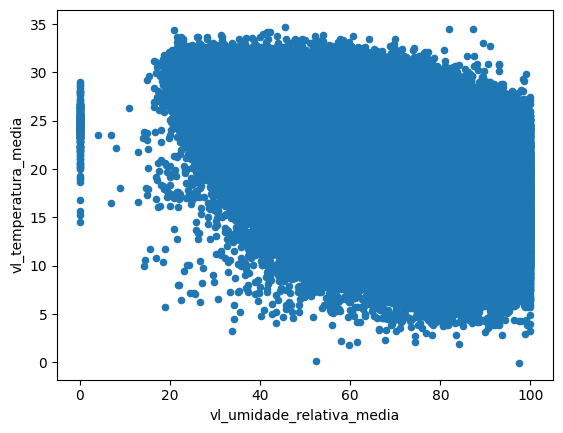

In [7]:
umidade = 'vl_umidade_relativa_media'
temperatura = 'vl_temperatura_media'
print(f"Correlação: Umidade Relativa Média e Temperatura Média: {abt[[umidade,temperatura]].corr().iloc[0].iloc[1]:.2f}")
abt[[umidade,temperatura]].plot.scatter(x=umidade,y=temperatura)

Correlação: Umidade Relativa Máxima e Temperatura Máxima: -0.16


<Axes: xlabel='vl_umidade_relativa_maxima', ylabel='vl_temperatura_maxima'>

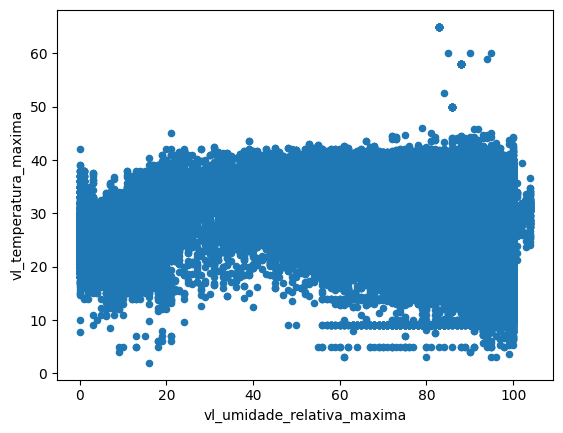

In [8]:
umidade = 'vl_umidade_relativa_maxima'
temperatura = 'vl_temperatura_maxima'
print(f"Correlação: Umidade Relativa Máxima e Temperatura Máxima: {abt[[umidade,temperatura]].corr().iloc[0].iloc[1]:.2f}")
abt[[umidade,temperatura]].dropna().plot.scatter(x=umidade,y=temperatura)

Correlação: Umidade Relativa Mínima e Temperatura Mínima: 0.14


<Axes: xlabel='vl_umidade_relativa_minima', ylabel='vl_temperatura_minima'>

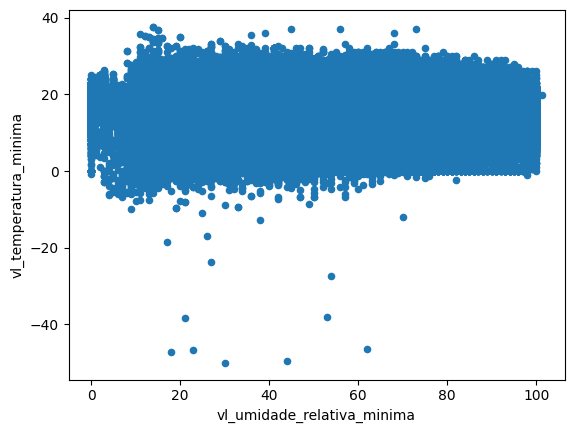

In [9]:
umidade = 'vl_umidade_relativa_minima'
temperatura = 'vl_temperatura_minima'
print(f"Correlação: Umidade Relativa Mínima e Temperatura Mínima: {abt[[umidade,temperatura]].corr().iloc[0].iloc[1]:.2f}")
abt[[umidade,temperatura]].dropna().plot.scatter(x=umidade,y=temperatura)

# Análises de Correlação

Correlação da umidade_relativa minima da estação base com a vizinha 1: 0.07
Correlação da umidade_relativa minima da estação base com a vizinha 2: 0.12
Correlação da umidade_relativa minima da estação base com a vizinha 3: 0.13
Correlação da umidade_relativa minima da estação base com a vizinha 4: 0.08
Correlação da umidade_relativa minima da estação base com a vizinha 5: 0.12
Correlação da umidade_relativa minima da estação base com a vizinha 6: 0.10
Correlação da umidade_relativa minima da estação base com a vizinha 7: 0.01
Correlação da umidade_relativa minima da estação base com a vizinha 8: 0.06
Correlação da umidade_relativa minima da estação base com a vizinha 9: 0.11
Correlação da umidade_relativa minima da estação base com a vizinha 10: 0.04
Correlação da umidade_relativa minima da estação base com a vizinha 11: 0.03
Correlação da umidade_relativa minima da estação base com a vizinha 12: 0.05

Correlação da umidade_relativa média da estação base com a vizinha 1: 0.74
Correlaçã

KeyError: "['vl_temperatura_media_vizinha_1'] not in index"

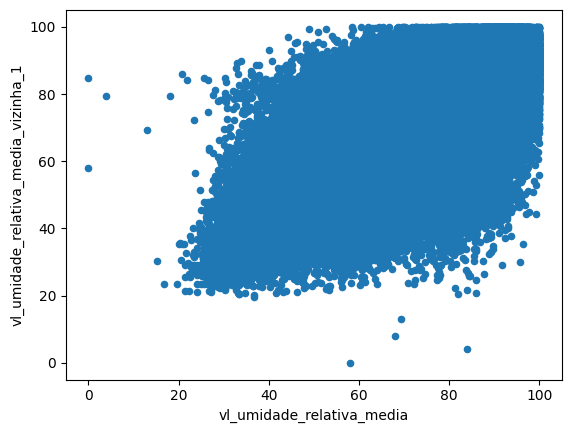

In [423]:
for i in range(1,13):
    print(f"Correlação da umidade_relativa minima da estação base com a vizinha {i}: {abt_bruto[['vl_umidade_relativa_minima',f'vl_umidade_relativa_minima_vizinha_{i}']].dropna().corr().iloc[0].iloc[1]:.2f}")
print()

for i in range(1,13):
    print(f"Correlação da umidade_relativa média da estação base com a vizinha {i}: {abt_bruto[['vl_umidade_relativa_media',f'vl_umidade_relativa_media_vizinha_{i}']].dropna().corr().iloc[0].iloc[1]:.2f}")
print()

for i in range(1,13):
    print(f"Correlação da umidade_relativa máxima da estação base com a vizinha {i}: {abt_bruto[['vl_umidade_relativa_maxima',f'vl_umidade_relativa_maxima_vizinha_{i}']].dropna().corr().iloc[0].iloc[1]:.2f}")
abt_bruto[['vl_umidade_relativa_media','vl_umidade_relativa_media_vizinha_1']].dropna().plot.scatter(x='vl_umidade_relativa_media',y='vl_umidade_relativa_media_vizinha_1')
for i in range(1,7):
    print(f"Correlação da temperatura minima da estação base com a vizinha {i}: {abt_bruto[['vl_temperatura_minima',f'vl_temperatura_minima_vizinha_{i}']].dropna().corr().iloc[0].iloc[1]:.2f}")
print()

for i in range(1,7):
    print(f"Correlação da temperatura média da estação base com a vizinha {i}: {abt_bruto[['vl_temperatura_media',f'vl_temperatura_media_vizinha_{i}']].dropna().corr().iloc[0].iloc[1]:.2f}")
print()

for i in range(1,7):
    print(f"Correlação da temperatura máxima da estação base com a vizinha {i}: {abt_bruto[['vl_temperatura_maxima',f'vl_temperatura_maxima_vizinha_{i}']].dropna().corr().iloc[0].iloc[1]:.2f}")
abt[['vl_temperatura_media','vl_temperatura_media_vizinha_1']].dropna().plot.scatter(x='vl_temperatura_media',y='vl_temperatura_media_vizinha_1')

# Funções de Análise do resultado

In [66]:
def plot_basic_metrics(metrics,suptitle = 'Métricas Básicas - Protótipo 1'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(list(metrics.values())[0].keys()): # Se não rodar, mudar metrics para dict_metrics e passar dict_metrics como argumento da função
        sns.barplot(data=pd.DataFrame(metrics).T.reset_index(),x='index',hue='index', y=metric, ax=ax[i])
        ax[i].set_title(f'{metric}')
        ax[i].set_xlabel('')
        ax[i].tick_params(axis='x', rotation=70)
        ax[i].grid()
        ax[i].set_axisbelow(True)

    fig.suptitle(suptitle,fontsize=17.5)
    plt.tight_layout()

    plt.show()
    return fig,ax

def plot_sem_chuva_metrics(predictions,threshold = 0.5):
    
    sem_chuva_dict = {model_name:prediction.loc[prediction['y_test']==0] for model_name,prediction in predictions.items()}
    acerto_dict = {model_name:len(df.loc[df['y_pred']==0])*100/len(df) for model_name,df in sem_chuva_dict.items()}
    proximo_dict = {model_name:len(df.loc[(df['y_pred']-df['y_test']).abs()<=threshold])*100/len(df) for model_name,df in sem_chuva_dict.items()}
    fig,ax = plt.subplots(1,2,figsize=(15, 5))

    sns.barplot(x=list(acerto_dict.keys()),hue=list(acerto_dict.keys()), y=list(acerto_dict.values()), ax=ax[0])
    ax[0].set_title('% Acerto')
    ax[0].tick_params(axis='x', rotation=70)
    ax[0].grid()
    ax[0].set_axisbelow(True)

    sns.barplot(x=list(proximo_dict.keys()),hue=list(acerto_dict.keys()), y=list(proximo_dict.values()), ax=ax[1])
    ax[1].set_title(f'% Previsão de menos de {threshold} mm')
    ax[1].tick_params(axis='x', rotation=70)
    ax[1].grid()
    ax[1].set_axisbelow(True)

    fig.suptitle("Previsões para dias não chuvosos",fontsize=17.5)
    plt.tight_layout()

def plot_com_chuva_metrics(predictions,threshold_list = [1,2,5]):
    com_chuva_dict = {model_name:prediction.loc[prediction['y_test']>0] for model_name,prediction in predictions.items()}

    proximo_dict = {threshold:{model_name:len(df.loc[(df['y_pred']-df['y_test']).abs()<=threshold])*100/len(df) for model_name,df in com_chuva_dict.items()} for threshold in threshold_list}
    fig,ax = plt.subplots(1,len(threshold_list),figsize=(15, 5))
    for i,threshold in enumerate(threshold_list):
        sns.barplot(x=list(proximo_dict[threshold].keys()),hue=list(proximo_dict[threshold].keys()), y=list(proximo_dict[threshold].values()), ax=ax[i])
        ax[i].set_title(f'% Erro de menos de {threshold} mm')
        ax[i].tick_params(axis='x', rotation=70)
        ax[i].grid()
        ax[i].set_axisbelow(True)

    fig.suptitle("Previsões para dias chuvosos",fontsize=17.5)
    plt.tight_layout()

def plot_com_muita_chuva_metrics(predictions,min_threshold_list = [5,10],max_threshold_list = [[1,2],[2,5]]):
    com_chuva_dict = {min_threshold:{model_name:prediction.loc[prediction['y_test']>min_threshold] for model_name,prediction in predictions.items()} for min_threshold in min_threshold_list}

    proximo_dict = {
        min_threshold:{
            max_threshold:{
                model_name:
                    len(com_chuva[model_name].loc[(com_chuva[model_name]['y_pred']-com_chuva[model_name]['y_test']).abs()<=max_threshold])*100/len(com_chuva[model_name]) 
                for model_name in com_chuva.keys()} 
            for max_threshold in max_threshold_list[i]}
        for i, (min_threshold, com_chuva) in enumerate(com_chuva_dict.items())
    }

    for min_threshold,max_dict in proximo_dict.items():
        fig,ax = plt.subplots(1,len(max_dict),figsize=(15, 5))
        for i,(max_threshold,data) in enumerate(max_dict.items()):
            sns.barplot(x = list(data),hue=list(data),y=list(data.values()),ax=ax[i])
            ax[i].set_title(f'% Erro de menos de {max_threshold} mm')
            ax[i].tick_params(axis='x', rotation=70)
            ax[i].grid()
            ax[i].set_axisbelow(True)
        fig.suptitle(f"Previsões para dias com mais de {min_threshold} mm de chuva",fontsize=17.5)
    

# Protótipos

In [67]:
# Funções para preenchimento de dados faltantes usando estações próximas
def preencher_com_vizinha(row,medida,cols_vizinhas):
    if pd.notnull(row[f'vl_{medida}']):
        return row[f'vl_{medida}']
    # Itera sobre as temperaturas vizinhas e retorna o primeiro valor não nulo
    return next((row[col] for col in cols_vizinhas if pd.notnull(row[col])), np.nan)

def fill_na_estacoes_vizinhas(abt,medida):
    cols_vizinhas = [f'vl_{medida}_vizinha_{i}' for i in range(1, 13)]
    return abt.apply(preencher_com_vizinha,medida=medida,cols_vizinhas=cols_vizinhas, axis=1)

def construir_abt_primaria(n_estacoes_vizinhas):
    # Importando a ABT Bruta pronta do database
    abt_bruto = sql("SELECT * FROM r2_ouro.abt_bruto")

    # Substituindo os dados -9999 por NaN, já que representam erros de medição
    abt = abt_bruto.replace(-9999,np.nan)

    # Preenchendo os valores nulos de temperatura e umidade com a estação vizinha mais próxima o possível
    for medida in ['temperatura_minima','temperatura_media','temperatura_maxima','umidade_relativa_minima','umidade_relativa_media']:
        abt[f'vl_{medida}'] = fill_na_estacoes_vizinhas(abt,medida)

    # Retirando as colunas auxiliares de temperatura e umidade das estações vizinhas
    abt = abt.drop([f'vl_{medida}_vizinha_{i}' for i in range(1,13) for medida in ['temperatura_minima','temperatura_media','temperatura_maxima','umidade_relativa_minima','umidade_relativa_media']]+[c for c in abt.columns if 'umidade_relativa_maxima' in c],axis=1)

    # Inserindo as informações de lat-lon
    dim_estacoes = sql("SELECT id_estacao,lat AS lat_estacao, lon AS lon_estacao FROM r2_prata.dim_estacoes")
    abt = abt.merge(dim_estacoes,on='id_estacao',how='inner')

    # Reordenando as colunas
    abt = abt[
        ['id_estacao','dt_medicao','lat_estacao','lon_estacao',
        'vl_temperatura_minima','vl_temperatura_media','vl_temperatura_maxima',
        'vl_umidade_relativa_minima','vl_umidade_relativa_media']+
        [item for i in range(1, n_estacoes_vizinhas+1) for item in (f'id_estacao_vizinha_{i}', f'vl_precipitacao_vizinha_{i}')]+
        ['vl_precipitacao' ]]

    # Corrigindo um bug de colunas duplicadas
    abt = abt.loc[:, ~abt.columns.duplicated()]

    return abt

from sklearn.base import clone

def treinar_prototipo(X_train,y_train,X_test,y_test,dict_models,dict_metrics):
    model = {model_name:clone(Regressor).fit(X_train,y_train) for model_name,Regressor in dict_models.items()}
    y_preds = {model_name:Regressor.predict(X_test) for model_name,Regressor in model.items()}
    metrics = {model_name:{metric_name:metric(y_pred,y_test) for metric_name,metric in dict_metrics.items()} for model_name,y_pred in y_preds.items()}
    predictions = {model_name:pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}) for model_name,y_pred in y_preds.items()}
    return model,metrics,predictions

def get_feature_importance(model,X):
    feature_importances = pd.DataFrame({'Variável':X.columns,'Feature Importance':model['Random Forest'].feature_importances_.tolist()})
    feature_importances.set_index('Variável').sort_values('Feature Importance',ascending=False).plot.bar()
    return feature_importances
        

In [32]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE,root_mean_squared_error as RMSE,r2_score as R2
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


satelites = ['AgCFSR','AgMERRA','CHIRPS','CPC','GL','GPM_Final_Run', 'GPM_Late_Run','PERSIANN_CDR','POWER','TRMM']


dict_models = {
    'Random Forest':RandomForestRegressor(n_estimators=200),
    'SVR':SVR(),
    'MLP':MLPRegressor(max_iter=1500,early_stopping=True)
    }

dict_metrics = {
    'MAE':MAE,
    'RMSE':RMSE,
    'R2':R2
}


## Protótipo 1

In [33]:
def criar_prototipo_1(n_estacoes_vizinhas,include_fl_mes_chuvoso):

    abt = construir_abt_primaria(n_estacoes_vizinhas=n_estacoes_vizinhas)
    abt['vl_umidade_relativa_media'] = np.where(abt['vl_umidade_relativa_media'].astype(float)>100,100,abt['vl_umidade_relativa_media'])
    abt['vl_umidade_relativa_minima'] = np.where(abt['vl_umidade_relativa_minima'].astype(float)>100,100,abt['vl_umidade_relativa_minima'])
    if include_fl_mes_chuvoso:
        abt['fl_mes_chuvoso'] = np.where(pd.to_datetime(abt['dt_medicao']).dt.month.isin([10,11,12,1,2,3]),1,0)

    abt_modeling = abt.drop(['id_estacao','dt_medicao']+[f'id_estacao_vizinha_{i}' for i in range(1,n_estacoes_vizinhas+1)],axis=1).dropna()
    abt_modeling = abt_modeling.loc[~abt_modeling['vl_precipitacao'].isna()]

    X = abt_modeling.drop('vl_precipitacao',axis=1)
    y = abt_modeling['vl_precipitacao']

    return X,y


In [34]:
# Separando variavel alvo das variaveis explicativas
X,y = criar_prototipo_1(n_estacoes_vizinhas=4,include_fl_mes_chuvoso=True)

# Normalizando os dados por z-score
Normalizador = StandardScaler()
X_normalizado = Normalizador.fit_transform(X,y)

# Separando em dataset de treino e de validação
X_train, X_test, y_train, y_test = train_test_split(
    X_normalizado, y, test_size=0.3, random_state=7)

KeyboardInterrupt: 

### Treinamento

In [9]:
# Treinando
model_1,metrics_1,predictions_1 = treinar_prototipo(X_train,y_train,X_test,y_test,dict_models,dict_metrics)

# Salvando os modelos
joblib.dump([model_1,metrics_1,predictions_1],f'prototipo_1.pkl')

['prototipo_1.pkl']

,Variável,Feature Importance
0,lat_estacao,0.040272
1,lon_estacao,0.045261
2,vl_temperatura_minima,0.046395
3,vl_temperatura_media,0.052480
4,vl_temperatura_maxima,0.047399
5,vl_umidade_relativa_minima,0.044141
6,vl_umidade_relativa_media,0.079779
7,vl_precipitacao_vizinha_1,0.290271
8,vl_precipitacao_vizinha_2,0.161873
9,vl_precipitacao_vizinha_3,0.089743


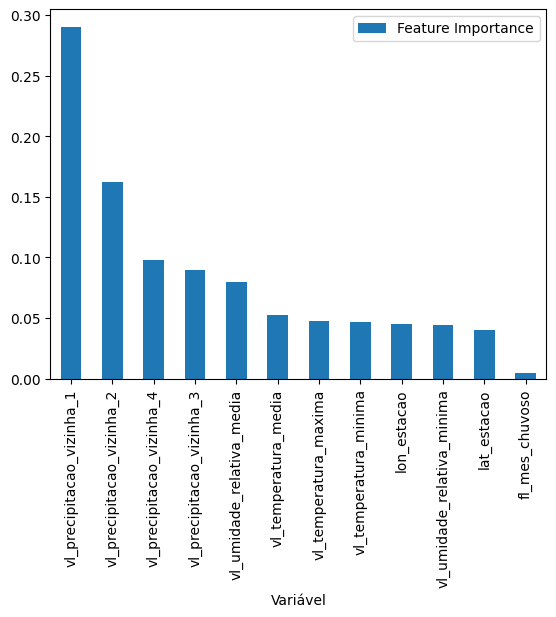

In [10]:
get_feature_importance(model_1,X)

## Protótipo 2

In [15]:
def criar_prototipo_2(n_estacoes_vizinhas,include_fl_mes_chuvoso,satelites):
    abt = sql("SELECT * FROM r2_ouro.ABT_satelite_all")

    abt['vl_umidade_relativa_media'] = np.where(abt['vl_umidade_relativa_media'].astype(float)>100,100,abt['vl_umidade_relativa_media'])
    abt['vl_umidade_relativa_minima'] = np.where(abt['vl_umidade_relativa_minima'].astype(float)>100,100,abt['vl_umidade_relativa_minima'])
    if include_fl_mes_chuvoso:
        abt['fl_mes_chuvoso'] = np.where(pd.to_datetime(abt['dt_medicao']).dt.month.isin([10,11,12,1,2,3]),1,0)


    abt_satelite = {
        satelite:
        abt.loc[~abt['vl_precipitacao'].isna(),
            ['vl_temperatura_minima','vl_temperatura_media','vl_temperatura_maxima','vl_umidade_relativa_minima','vl_umidade_relativa_media','fl_mes_chuvoso']+
            [f'vl_precipitacao_vizinha_{i}' for i in range(1,n_estacoes_vizinhas+1)]+
            [c for c in abt if satelite in c]+
            ['vl_precipitacao']].dropna()
            for satelite in satelites}
    
    abt_modeling = {satelite:df.loc[~df['vl_precipitacao'].isna()] for satelite,df in abt_satelite.items()}

    X = {satelite:df.drop('vl_precipitacao',axis=1) for satelite,df in abt_modeling.items()}
    y = {satelite:df['vl_precipitacao'] for satelite,df in abt_modeling.items()}

    return X,y

### Modelagem

In [20]:
satelites = ['AgCFSR','AgMERRA','CHIRPS','CPC','GL','GPM_Final_Run', 'GPM_Late_Run','PERSIANN_CDR','POWER','TRMM']

X,y = criar_prototipo_2(n_estacoes_vizinhas=4,include_fl_mes_chuvoso=True,satelites=satelites)

Normalizador = StandardScaler()
X_normalizado = {satelite:Normalizador.fit_transform(X[satelite],y[satelite]) for satelite in satelites}

X_train,X_test,y_train,y_test = {},{},{},{}
for satelite in satelites:
    X_train[satelite],X_test[satelite],y_train[satelite],y_test[satelite] = train_test_split(
        X_normalizado[satelite],
        y[satelite],
        test_size=0.3
    )

### Treinamento

In [9]:
model_2,metrics_2,predictions_2 = {},{},{}

for satelite in satelites:
    print(f'Treinando com satélite {satelite}')
    model_2[satelite],metrics_2[satelite],predictions_2[satelite] = treinar_prototipo(X_train[satelite],y_train[satelite],X_test[satelite],y_test[satelite],dict_models,dict_metrics)

Treinando com satélite AgCFSR
Treinando com satélite AgMERRA
Treinando com satélite CHIRPS
Treinando com satélite CPC
Treinando com satélite GL
Treinando com satélite GPM_Final_Run
Treinando com satélite GPM_Late_Run
Treinando com satélite PERSIANN_CDR
Treinando com satélite POWER
Treinando com satélite TRMM


In [10]:
# Salvando os modelos
joblib.dump([model_2,metrics_2,predictions_2],f'prototipo_2.pkl')

['prototipo_2.pkl']

## Protótipo 3

In [115]:
def criar_prototipo_3(n_estacoes_vizinhas,include_fl_mes_chuvoso,satelites):
    abt = sql("SELECT * FROM r2_ouro.ABT_satelite_all WHERE YEAR(CAST(dt_medicao AS DATE))>=2016 AND vl_precipitacao <= 80 AND vl_precipitacao>=0")

    abt['vl_umidade_relativa_media'] = np.where(abt['vl_umidade_relativa_media'].astype(float)>100,100,abt['vl_umidade_relativa_media'])
    abt['vl_umidade_relativa_minima'] = np.where(abt['vl_umidade_relativa_minima'].astype(float)>100,100,abt['vl_umidade_relativa_minima'])
    if include_fl_mes_chuvoso:
        abt['fl_mes_chuvoso'] = np.where(pd.to_datetime(abt['dt_medicao']).dt.month.isin([10,11,12,1,2,3]),1,0)


    abt_satelite = {
        satelite:
        abt.loc[~abt['vl_precipitacao'].isna(),
            ['vl_temperatura_minima','vl_temperatura_media','vl_temperatura_maxima','vl_umidade_relativa_minima','vl_umidade_relativa_media','fl_mes_chuvoso']+
            [f'vl_precipitacao_vizinha_{i}' for i in range(1,n_estacoes_vizinhas+1)]+
            [c for c in abt if satelite in c]+
            ['vl_precipitacao']]
            for satelite in satelites}
    
    abt_modeling = {satelite:df.loc[~df['vl_precipitacao'].isna()] for satelite,df in abt_satelite.items()}

    X = {satelite:df.drop('vl_precipitacao',axis=1) for satelite,df in abt_modeling.items()}
    y = {satelite:df['vl_precipitacao'] for satelite,df in abt_modeling.items()}

    return X,y

In [116]:
satelites = ['CHIRPS','CPC','GL','GPM_Final_Run', 'GPM_Late_Run','PERSIANN_CDR','POWER','TRMM']

X,y = criar_prototipo_3(n_estacoes_vizinhas=12,include_fl_mes_chuvoso=True,satelites=satelites)

Normalizador = StandardScaler()
X_normalizado = {satelite:Normalizador.fit_transform(X[satelite],y[satelite]) for satelite in satelites}

X_train,X_test,y_train,y_test = {},{},{},{}
for satelite in satelites:
    X_train[satelite],X_test[satelite],y_train[satelite],y_test[satelite] = train_test_split(
        X[satelite],
        y[satelite],
        test_size=0.3
    )

In [117]:
len(X_train['GPM_Final_Run'])

213989

In [118]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(n_estimators=10000,subsample=0.8,min_child_weight=10,max_depth=10,learning_rate=0.01,gamma=0,colsample_bytree=0.7)

xgboost.fit(X_train['GPM_Late_Run'],y_train['GPM_Late_Run'])
#92477

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [119]:
y_pred = xgboost.predict(X_test['GPM_Late_Run'])

In [120]:
R2(y_pred,y_test['GPM_Late_Run'])
# 0.0507
# 0.09
# Sem tirar os nulos: 0.04

0.061259020615673676

In [125]:
conn.close()

In [100]:
fi_dict = {k:v for k,v in zip(xgboost.feature_names_in_,xgboost.feature_importances_)}
for c in sorted(fi_dict,key=fi_dict.get,reverse=True):
    print(f"{c}: {fi_dict[c]}")

vl_precipitacao_GPM_Late_Run: 0.2883412539958954
vl_precipitacao_vizinha_1: 0.12737026810646057
vl_precipitacao_vizinha_2: 0.11143659055233002
vl_precipitacao_vizinha_3: 0.08348765969276428
vl_precipitacao_vizinha_4: 0.0788474828004837
vl_umidade_relativa_media: 0.055165305733680725
vl_temperatura_minima: 0.05444205179810524
vl_temperatura_media: 0.05330757424235344
vl_temperatura_maxima: 0.0531388595700264
vl_umidade_relativa_minima: 0.050353437662124634
fl_mes_chuvoso: 0.04410957917571068


### Modelagem

In [76]:
model_3,metrics_3,predictions_3 = {},{},{}

for satelite in satelites:
    print(f'Treinando com satélite {satelite}')
    model_3[satelite],metrics_3[satelite],predictions_3[satelite] = treinar_prototipo(X_train[satelite],y_train[satelite],X_test[satelite],y_test[satelite],dict_models,dict_metrics)

Treinando com satélite CHIRPS
Treinando com satélite CPC
Treinando com satélite GL
Treinando com satélite GPM_Final_Run
Treinando com satélite GPM_Late_Run
Treinando com satélite PERSIANN_CDR
Treinando com satélite POWER
Treinando com satélite TRMM


In [77]:
# Salvando os modelos
joblib.dump([model_3,metrics_3,predictions_3],f'prototipo_3.pkl')

['prototipo_3.pkl']

## Comparação

In [78]:
from funcoes_comparacao import plot_radar,comparar_prototipos_sem_chuva,comparar_prototipos_com_chuva,comparar_prototipos_com_muita_chuva,comparar_prototipos_metricas_basicas

In [79]:
import joblib

model_1,metrics_1,predictions_1 = joblib.load('prototipo_1.pkl')
model_2,metrics_2,predictions_2 = joblib.load('prototipo_2.pkl')
model_3,metrics_3,predictions_3 = joblib.load('prototipo_3.pkl')


satelites = ['AgCFSR','AgMERRA','CHIRPS','CPC','GL','GPM_Final_Run', 'GPM_Late_Run','PERSIANN_CDR','POWER','TRMM']
models = ['Random Forest','SVR','MLP']

In [90]:
metrics_3

{'CHIRPS': {'Random Forest': {'MAE': 2.8220835081459055,
   'RMSE': 6.536361686688455,
   'R2': -0.07584385901212243},
  'SVR': {'MAE': 2.450217045567352,
   'RMSE': 7.012341255454409,
   'R2': -1.5147484334088288},
  'MLP': {'MAE': 2.766496867272171,
   'RMSE': 6.481424200679689,
   'R2': -0.1877719797874866}},
 'CPC': {'Random Forest': {'MAE': 2.79352689345959,
   'RMSE': 6.372632528622703,
   'R2': -0.05566745206103785},
  'SVR': {'MAE': 2.375612732610124,
   'RMSE': 6.796982217513396,
   'R2': -1.4345009973938514},
  'MLP': {'MAE': 2.7994315157474716,
   'RMSE': 6.304491356663879,
   'R2': -0.15806532458526656}},
 'GL': {'Random Forest': {'MAE': 2.7929741682886395,
   'RMSE': 6.423916799185162,
   'R2': -0.06025764654397614},
  'SVR': {'MAE': 2.3976675111495562,
   'RMSE': 6.88727020734205,
   'R2': -1.5160343658256563},
  'MLP': {'MAE': 2.7374985185234073,
   'RMSE': 6.376886157579083,
   'R2': -0.30465206458105265}},
 'GPM_Final_Run': {'Random Forest': {'MAE': 2.6510656231815535,

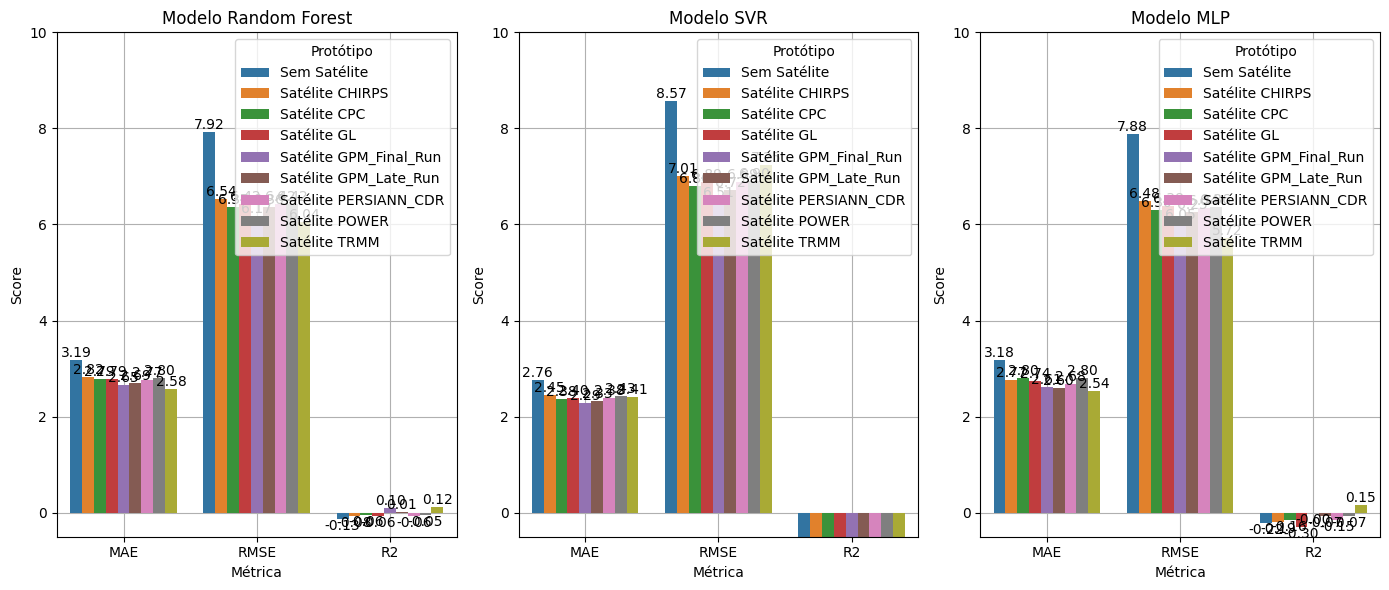

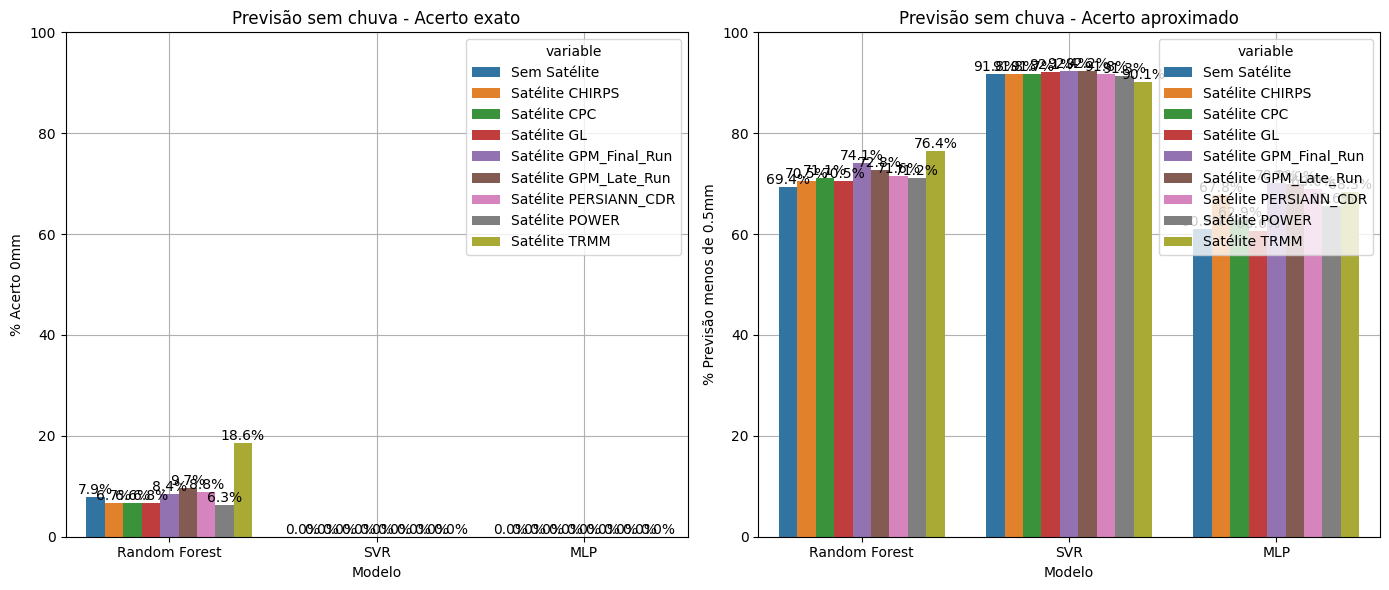

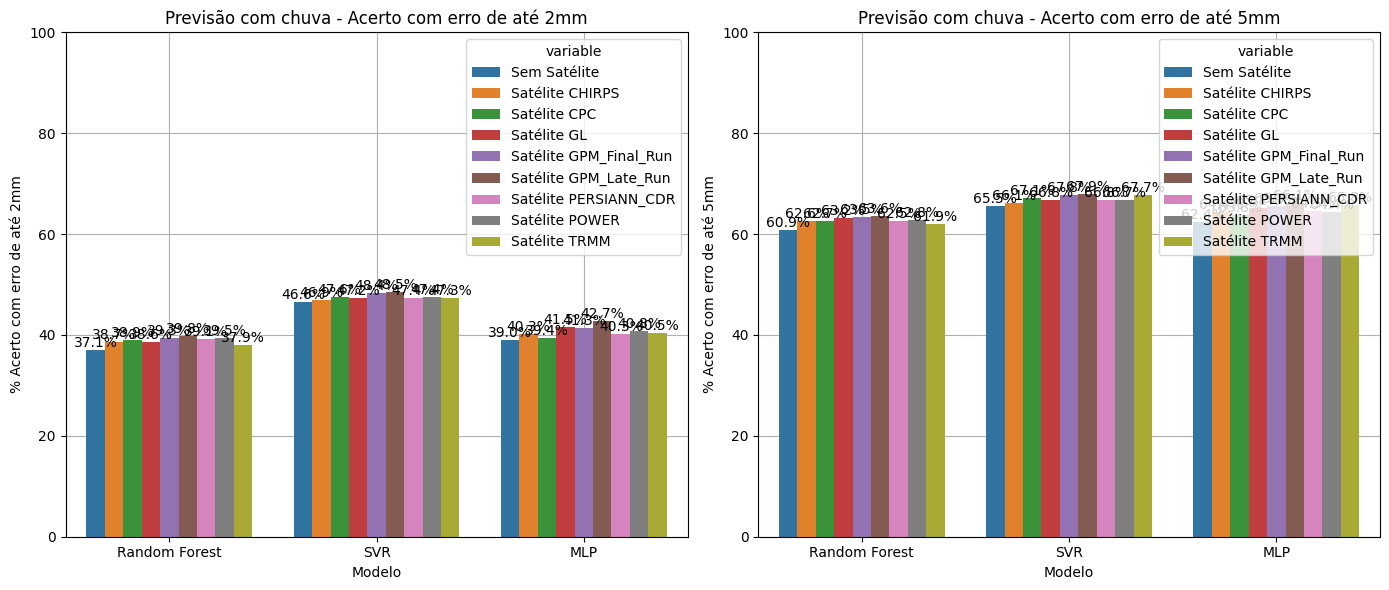

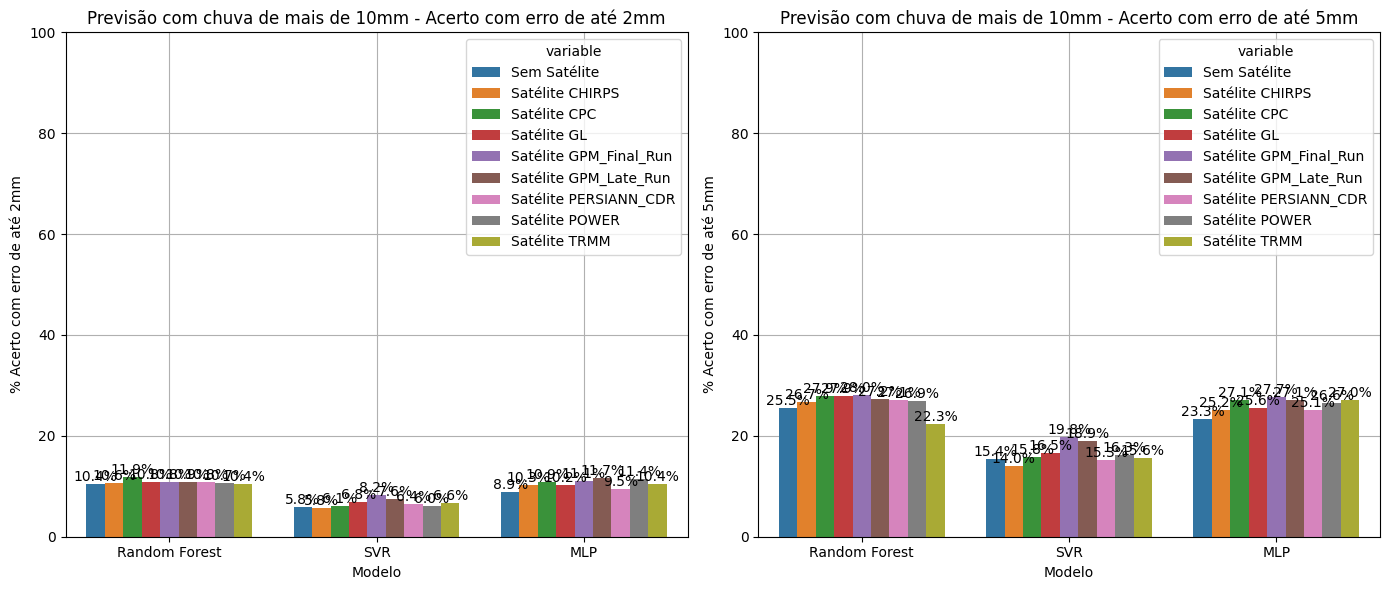

In [81]:
satelites_plots = ['CHIRPS',
 'CPC',
 'GL',
 'GPM_Final_Run',
 'GPM_Late_Run',
 'PERSIANN_CDR',
 'POWER',
 'TRMM']
# satelites_plots = satelites
metrics_list = [metrics_1]+[metrics_3[satelite] for satelite in satelites_plots]
predictions_list = [predictions_1]+[predictions_3[satelite] for satelite in satelites_plots]
titles_list = ['Sem Satélite']+[f'Satélite {x}' for x in satelites_plots]

comparar_prototipos_metricas_basicas(metrics_list,titles_list)
comparar_prototipos_sem_chuva(predictions_list,titles_list)
comparar_prototipos_com_chuva(predictions_list,titles_list,2,5)
comparar_prototipos_com_muita_chuva(predictions_list,titles_list,10,2,5)

In [ ]:
def plot_comparacao_radar(satelites_plots,modelo,threshold_acerto_sem_chuva = 0.5,min_muita_chuva = 10,threshold_acerto_com_chuva = 2,threshold_acerto_com_muita_chuva = 5,display_values=False,predictions_list=[predictions_1,predictions_2],plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
               '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
               '#bcbd22', '#17becf']):

    final_predictions_list = [predictions_list[0]]+[v for k,v in predictions_list[1].items() if k in satelites_plots]
    titles_list=['Sem Satélite']+[f'Satélite {x}' for x in satelites_plots]
    modelos_plot = [('Sem Satélite',modelo)]+[(f'Satélite {satelite}',modelo) for satelite in satelites_plots]
    predictions_dict = {titles_list[i]:prototipo for i,prototipo in enumerate(final_predictions_list)}

    sem_chuva = {
            prototipo:{
                model:df.loc[df['y_test']==0] for model,df in prediction.items()}
            for prototipo,prediction in predictions_dict.items()}

    com_chuva = {
            prototipo:{
                model:df.loc[df['y_test']>0] for model,df in prediction.items()}
            for prototipo,prediction in predictions_dict.items()}

    com_muita_chuva = {
            prototipo:{
                model:df.loc[df['y_test']>min_muita_chuva] for model,df in prediction.items()}
            for prototipo,prediction in predictions_dict.items()}


    sem_chuva_acerto = {
            prototipo: {
                model:len(df.loc[df['y_pred']==0])*100/len(df) for model,df in prediction.items()}
            for prototipo,prediction in sem_chuva.items()
        }

    sem_chuva_proximo = {
        prototipo: {
            model:len(df.loc[df['y_pred']<=threshold_acerto_sem_chuva])*100/len(df) for model,df in prediction.items()}
        for prototipo,prediction in sem_chuva.items()
    }


    com_chuva_proximo = {
            prototipo: {
                model:len(df.loc[(df['y_pred']-df['y_test']).abs()<=threshold_acerto_com_chuva])*100/len(df) for model,df in prediction.items()}
            for prototipo,prediction in com_chuva.items()
        }

    com_muita_chuva_proximo = {
        prototipo: {
            model:len(df.loc[(df['y_pred']-df['y_test']).abs()<=threshold_acerto_com_muita_chuva])*100/len(df) for model,df in prediction.items()}
        for prototipo,prediction in com_muita_chuva.items()
    }

    sem_chuva_acerto_df = pd.melt(pd.DataFrame(sem_chuva_acerto).reset_index(names='Modelo'),id_vars='Modelo',var_name='Protótipo',value_name='%')
    sem_chuva_acerto_df['Métrica'] = 'S/C'

    sem_chuva_proxima_df = pd.melt(pd.DataFrame(sem_chuva_proximo).reset_index(names='Modelo'),id_vars='Modelo',var_name='Protótipo',value_name='%')
    sem_chuva_proxima_df['Métrica'] = '~S/C'

    com_chuva_proxima_df = pd.melt(pd.DataFrame(com_chuva_proximo).reset_index(names='Modelo'),id_vars='Modelo',var_name='Protótipo',value_name='%')
    com_chuva_proxima_df['Métrica'] = '~C/C'

    com_muita_chuva_proxima_df = pd.melt(pd.DataFrame(com_muita_chuva_proximo).reset_index(names='Modelo'),id_vars='Modelo',var_name='Protótipo',value_name='%')
    com_muita_chuva_proxima_df['Métrica'] = '~M/C'

    metricas_radar = pd.concat([sem_chuva_acerto_df,sem_chuva_proxima_df,com_chuva_proxima_df,com_muita_chuva_proxima_df])


    plot_df = pd.concat([metricas_radar.loc[(metricas_radar['Modelo']==row[1])&(metricas_radar['Protótipo']==row[0])] for row in modelos_plot])

    plot_radar(plot_df,label='Métrica',value='%',hue='Protótipo',display_values=display_values,plot_colors=plot_colors,title='Comparação em Radar',labels_font_color='black',fill_alpha=0.25/len(satelites_plots))

    pass

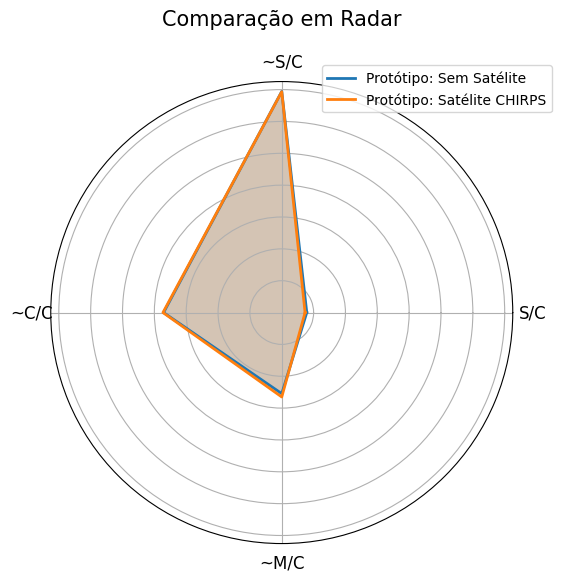

In [154]:
plot_comparacao_radar(['CHIRPS'],'Random Forest')

## Passos

In [ ]:
# FEITO: Concatenar todas as estações 
# FEITO: Checar por valores -9999, que representam ruídos 
# DÚVIDA: Existem medições de umidade relativa acima de 100%. Isso é possível?
# FEITO: Testar correlação entre umidade e temperatura (a correlação é baixa)
# FEITO: Testar correlação entre temperatura da estação base e das estações vizinhas (alta correlação, principalmente com as primeiras estações)
# FEITO: Preenchimento de dados faltantes de temperatura usando estações próximas (falta validar alguns casos pra ter certeza)
# Estratégia de preenchimento de dados faltantes de umidade (correlação alta na mínima e média, baixa na máxima. Decidi descartar a umidade relativa máxima)
# FEITO: Retirada das colunas auxiliares de temperatura e umidades vizinhas
# FEITO: Descarte de todas as colunas de umidade relativa maxima (Pouca correlação, muitos missings, poucas correlações entre as estações vizinhas)
# FEITO: Lidar com os dados nulos restantes (mantive apenas 6 estações próximas, dropei todos as outras linhas com nulo, ficaram 71k linhas)
# FEITO: Normalização dos dados
# FEITO: Separação do dataset em treinamento em validação (futuramente, definir backtests)
# FEITO: Rodar um random forest, um SVM Regressor
# FEITO: Obter valores 'v0' do modelo
# FEITO: fazer os joins dos satelites por pyspark
# FEITO: Funções para comparar os protótipos de forma dinâmica
# FEITO: Investigar os joins de satélite, rever porque perco tantos dados, se está certo mesmo
# FEITO: Incrementar os dados de satélite
#   - FEITO: Correlação entre dado do satélite no lat-lon mais próximo à estação com a medição da estação
#   - FEITO: Comparar o erro do novo modelo com o erro do satélite
# FEITO: Criar visuais para o resultado do modelo
# FEITO:Criar coluna de flag dias chuvosos (Verificar nos dados)
# FEITO: Umidade: Quando for maior que 100, travar em 100
# FEITO: Retirar os dados de lat lon
# FEITO: gráficos de radar sem satelite x 1 satelite
# preciso corrigir um bug na hra de colocar mais de 1 satelite no grafico de radar
# variavel de diferença de temperatura do dia anterior pro dia atual
# erro percentual de mm de chuva
# Variável alvo: Teste de 10 dias
# testar combinação TRMM + AgCFSR
# Remover outliers: precipitação com valores muito altos




#   - Modelos mensais? (variaveis complexas: angulos, apenas para modelos de redes neurais complexas)

# Ideia de mudar variavel alvo, sendo porcentagem do mês (valor do dia/total médio da chuva no mes)

In [ ]:
def plot_radar(labels, values, title="Gráfico de Radar", color='blue', fill_alpha=0.25):
    """
    Função para plotar um gráfico de radar com valores exibidos em cada ponto e labels fora do gráfico.
    
    Parâmetros:
    - labels (list): Lista de rótulos para cada eixo do gráfico.
    - values (list): Lista de valores correspondentes a cada rótulo.
    - title (str): Título do gráfico (opcional).
    - color (str): Cor da linha e preenchimento do gráfico (opcional).
    - fill_alpha (float): Transparência do preenchimento do gráfico (opcional).
    """
    # Número de variáveis
    num_vars = len(labels)

    # Ângulos para cada variável no gráfico de radar, começando no topo (90 graus)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles = [angle + np.pi / 2 for angle in angles]  # Ajuste para iniciar no topo
    
    # Repetir o primeiro valor e ângulo no final para fechar o gráfico
    values += values[:1]
    angles += angles[:1]
    labels += labels[:1]  # Repetir o primeiro label para corresponder ao fechamento do gráfico

    # Configuração do gráfico de radar
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Centralização do título com espaçamento ajustado
    ax.set_title(title, size=15, color=color, pad=30, ha='center')
    
    # Desenho do gráfico
    ax.fill(angles, values, color=color, alpha=fill_alpha)
    ax.plot(angles, values, color=color, linewidth=2)

    # Adicionar valores em cada ponto do gráfico
    for angle, value in zip(angles, values):
        ax.text(angle, value + 0.1, f'{value:.2f}', ha='center', va='center', fontsize=10, color=color)

    # Posicionar os labels fora do gráfico, radialmente mais distantes
    label_offset = max(values) + 1  # Aumenta o valor do deslocamento para tornar os labels mais distantes
    for angle, label in zip(angles, labels):
        ax.text(angle, label_offset, label, ha='center', va='center', fontsize=12, color=color)

    # Configuração dos eixos
    ax.set_yticklabels([])  # Remove rótulos do eixo radial
    ax.set_xticks([])  # Remove rótulos automáticos dos ângulos

    # Ajuste de margens para centralizar
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()

# Outro

In [36]:
# abt = construir_abt_primaria(n_estacoes_vizinhas=4)
# abt['vl_umidade_relativa_media'] = np.where(abt['vl_umidade_relativa_media'].astype(float)>100,100,abt['vl_umidade_relativa_media'])
# abt['vl_umidade_relativa_minima'] = np.where(abt['vl_umidade_relativa_minima'].astype(float)>100,100,abt['vl_umidade_relativa_minima'])
# abt['fl_mes_chuvoso'] = np.where(pd.to_datetime(abt['dt_medicao']).dt.month.isin([10,11,12,1,2,3]),1,0)

abt_modeling = abt.drop(['id_estacao','dt_medicao']+[f'id_estacao_vizinha_{i}' for i in range(1,4+1)],axis=1).dropna()
abt_modeling = abt_modeling.loc[~abt_modeling['vl_precipitacao'].isna()]

# X = abt_modeling.drop('vl_precipitacao',axis=1)
# y = abt_modeling['vl_precipitacao']

In [ ]:
sql(show_tables_prata_query)

,table_name
0,fato_satelite_AgMERRA
1,fato_satelite_CPC
2,fato_estacao_ANA
3,fato_estacao_CEMADEN
4,fato_estacao_UNESP
5,dim_estacoes
6,fato_satelite_PERSIANN_CDR
7,fato_estacoes_precipitacao
8,fato_satelite_CHIRPS
9,fato_satelite_GPM_Final_Run


In [ ]:
id_estacao = 575953